In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#importing necessary libraries
import pandas as pd;
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


In [37]:
#importing the IMDB Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/IMDB_Dataset.csv')
df.reset_index(drop=True, inplace=True)

display(df.head())
print(f'\n\033[1mInerence:\033[0m The Dataset consists of {df.shape[1]} features & {df.shape[0]} samples.')

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Inerence: The Dataset consists of 2 features & 50000 samples.


In [38]:
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [39]:
# Updating positive sentiment with class value 1
df.loc[df['sentiment'] == 'positive', 'sentiment'] = 1

# Updating negative sentiment with class value 0
df.loc[df['sentiment'] == 'negative', 'sentiment'] = 0

# Converting the sentiment column to integer type
df['sentiment'] = df['sentiment'].astype(int)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [40]:

#Checking the dtypes of all the columns
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [41]:
#Checking the stats of all the columns
display(df.describe())

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


# Data Preprocessing

In [42]:
#Checking for empty elements
display(df.isnull().sum())
print('\n\033[1mInference:\033[0m The dataset doesn\'t have any null elements')

,0
review,0
sentiment,0



Inference: The dataset doesn't have any null elements


In [43]:
#Removing duplicate row (if any)

counter = 0
r,c = df.shape

dfNew =  df.drop_duplicates()
dfNew.reset_index(drop=True, inplace=True)

if dfNew.shape==(r,c):
   print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-dfNew.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 418


In [44]:
#Filtering the text

import nltk
nltk.download('stopwords')
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string

df = dfNew.copy()


def Preprocessing(text):
  #Removing html tags
  text = re.sub(r'<.*?>', '', text)

  # lowercasing text for uniformility
  text = text.lower()

  #Remove non-alphabetcial characters (keep spaces)
  text = ''.join([i for i in text if i in string.ascii_lowercase+ ' '])

  #Stemming and stop word removal
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))

  #Stem and remove stopwords
  text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])

  return text

#Applying the function with progess bar using tqdm
tqdm.pandas()
df['review'] = df['review'].progress_apply(Preprocessing)

# Clean data
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 49582/49582 [02:27<00:00, 335.10it/s]

                                              review  sentiment
0  one review mention watch oz episod youll hook ...          1
1  wonder littl product film techniqu unassum old...          1
2  thought wonder way spend time hot summer weeke...          1
3  basic there famili littl boy jake think there ...          0
4  petter mattei love time money visual stun film...          1


In [45]:
#review text display
display(df.iloc[1]['review'])

#data clean and Stem successfully

print('\n\033[1mIference:\033[0m The text is now clean up with the removal of all punctuations, stopwords & stemming.')

'wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'


Iference: The text is now clean up with the removal of all punctuations, stopwords & stemming.


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
  return text.split()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer_porter, use_idf=True, norm='l2', smooth_idf=True)

y= df['sentiment'].values
x= tfidf.fit_transform(df['review'])

print(f'Shape of X: {x.shape}')
print(f'Shape of Y: {y.shape}')


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Shape of X: (49582, 172810)
Shape of Y: (49582,)


# Exploratory Data Analysis (EDA)

            Target Variable Distribution           


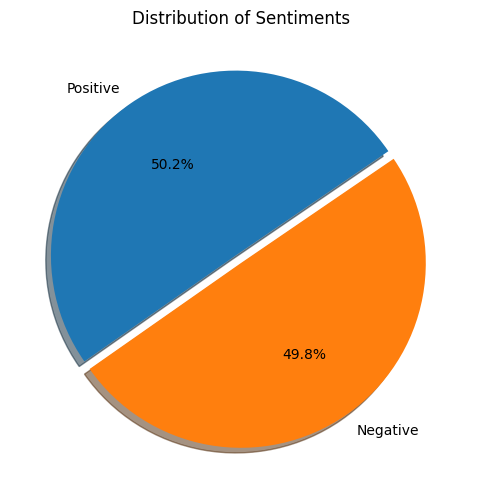


Inference: The Target Variable seems to be perfectly balanced!


In [47]:
#Let us first analyze the distribution of the target variable i.e y
print('\033[1mTarget Variable Distribution'.center(55))

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    df['sentiment'].value_counts(),
    labels=['Positive', 'Negative'],
    counterclock=False,
    shadow=True,
    explode=[0.05, 0],
    autopct='%1.1f%%',
    radius=1,
    startangle=215
)
plt.title('Distribution of Sentiments')
plt.show()

print('\n\033[0mInference:\033[0m The Target Variable seems to be perfectly balanced!')

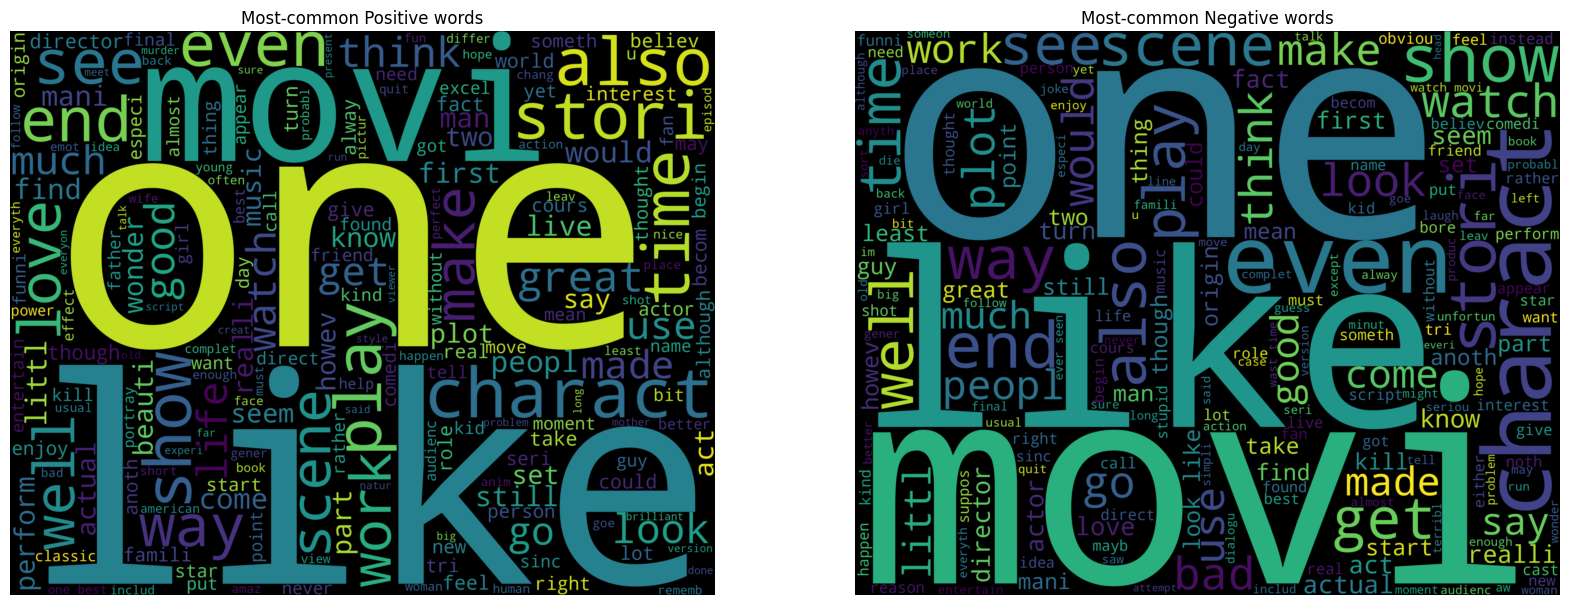

In [48]:
#Visuallizing the Word cloud for positive and negative sentiments
positiveData = df[df['sentiment'] == 1]['review']
negativeData = df[df['sentiment'] == 0]['review']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    clean_word = " ".join([word for word in words.split() if word not in ['movie', 'film']])
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color=color, width=2500, height=2000).generate(clean_word)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20, 10])

# Positive words cloud
plt.subplot(1, 2, 1)
wordcloud_draw(positiveData, 'black', 'Most-common Positive words')

# Negative words cloud
plt.subplot(1, 2, 2)
wordcloud_draw(negativeData, 'black', 'Most-common Negative words')

plt.show()

In [49]:
# Splitting the data into training & testing sets

Train_X, Test_X, Train_Y, Test_Y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

print(f'Original set ---> {x.shape} \nTraining set ---> {Train_X.shape}, {Train_Y.shape}\nTesting set ---> {Test_X.shape}, {Test_Y.shape}')


Original set ---> (49582, 172810) 
Training set ---> (39665, 172810), (39665,)
Testing set ---> (9917, 172810), (9917,)


In [50]:
#Let us create a table to store results for both models

Evaluation_Results = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC score'])
Evaluation_Results.index= ['Naive Bayes (NB)', 'Random Forest (RF)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-Score,AUC-ROC score
Naive Bayes (NB),0.0,0.0,0.0,0.0,0.0
Random Forest (RF),0.0,0.0,0.0,0.0,0.0


In [51]:
# Function to summarise the Prediction's Scores.

def Classification_Summary(pred,pred_prob,i):
    accuracy = round(accuracy_score(Test_Y, pred), 3) * 100
    precision = round(precision_score(Test_Y, pred), 3) * 100
    recall = round(recall_score(Test_Y, pred), 3) * 100
    f1 = round(f1_score(Test_Y, pred), 3) * 100
    auc_roc = round(roc_auc_score(Test_Y, pred), 3) * 100

    # Update Evaluation_Results DataFrame
    Evaluation_Results.iloc[i] = [accuracy, precision, recall, f1, auc_roc]

    print(f'<<<{"-"*35} Evaluating {Evaluation_Results.index[i]} {"-"*35}>>>')
    print(f'Accuracy: {accuracy}%')
    print(f'Precision: {precision}%')
    print(f'Recall: {recall}%')
    print(f'F1 Score: {f1}%')
    print(f'AUC-ROC Score: {auc_roc}%')
    print(f'\n\033[1mConfusion Matrix:\033[0m\n{confusion_matrix(Test_Y, pred)}')
    print(f'\n\033[1mClassification Report:\033[0m\n{classification_report(Test_Y, pred)}')

    # Visualize the AUC-ROC curve
    AUC_ROC_plot(Test_Y, pred_prob)

def AUC_ROC_plot(Test_Y,pred_prob):
  ref = [0 for _ in range(len(Test_Y))]
  ns_fpr,ns_tpr, _ = roc_curve(Test_Y,ref)
  lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred_prob)
  auc_score = roc_auc_score(Test_Y,pred_prob)* 100

  plt.figure(figsize=(8,6))
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label=f'AUC = {auc_score:.2f}%')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC-ROC Curve')
  plt.legend()
  plt.show()


# Naive Bayes Classifier

<<<----------------------------------- Evaluating Naive Bayes (NB) ----------------------------------->>>
Accuracy: 84.0%
Precision: 86.2%
Recall: 81.3%
F1 Score: 83.7%
AUC-ROC Score: 84.0%

Confusion Matrix:
[[4260  649]
 [ 938 4070]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      4909
           1       0.86      0.81      0.84      5008

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



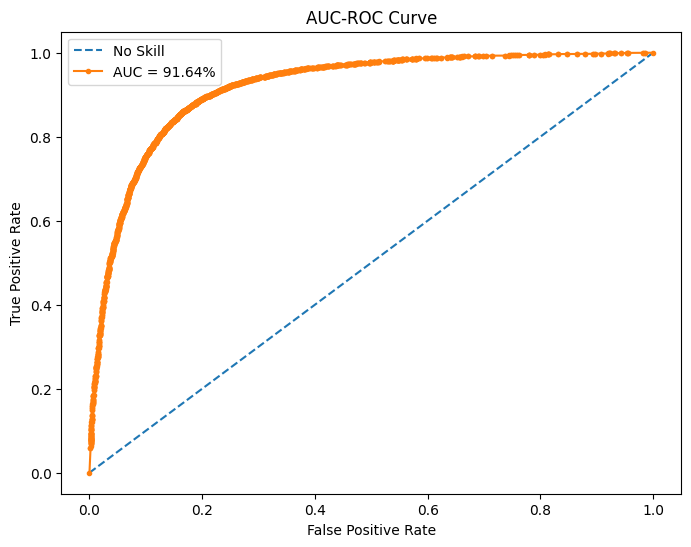

In [52]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X,Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)[:,1]
Classification_Summary(pred,pred_prob,0)

# Random Forest Classifier:

<<<----------------------------------- Evaluating Random Forest (RF) ----------------------------------->>>
Accuracy: 84.3%
Precision: 84.39999999999999%
Recall: 84.5%
F1 Score: 84.5%
AUC-ROC Score: 84.3%

Confusion Matrix:
[[4124  785]
 [ 774 4234]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4909
           1       0.84      0.85      0.84      5008

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



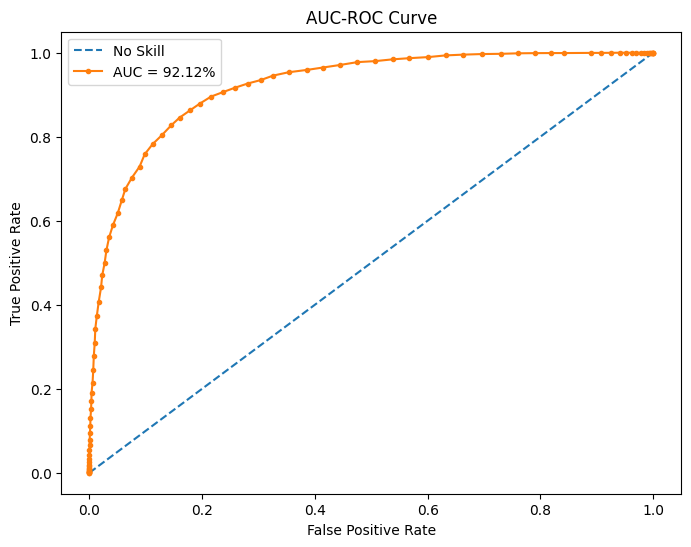

In [53]:
# Building Random Forest Classifier

RF_model = RandomForestClassifier()
RF = RF_model.fit(Train_X,Train_Y)
pred = RF.predict(Test_X)
pred_prob = RF.predict_proba(Test_X)[:,1]
Classification_Summary(pred,pred_prob,1)

In [54]:
# Displaying Evaluation Results
Evaluation_Results

,Accuracy,Precision,Recall,F1-Score,AUC-ROC score
Naive Bayes (NB),84.0,86.2,81.3,83.7,84.0
Random Forest (RF),84.3,84.4,84.5,84.5,84.3


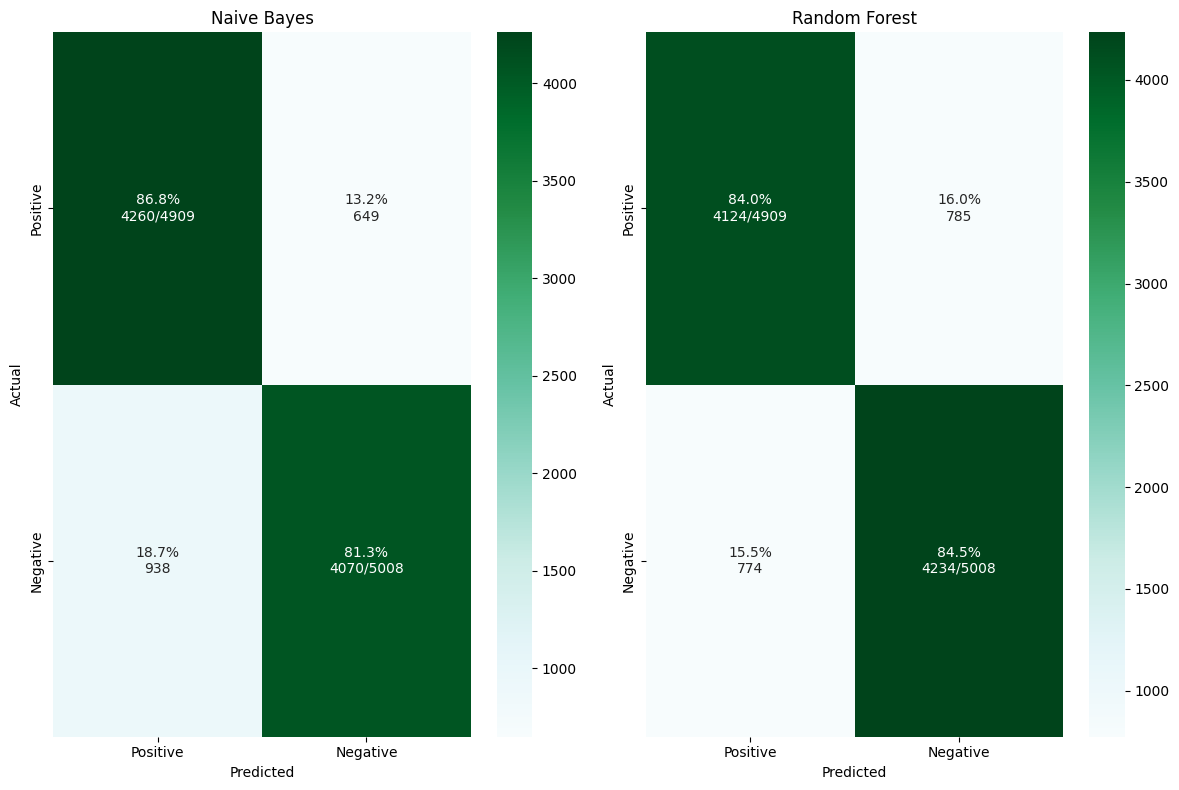

In [55]:
# Plotting Confusion-Matrix of Naive Bayes & Random Forest Classifiers

labels = ['Positive', 'Negative']

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = f'{p:.1f}%\n{c}/{s[0]}'
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = f'{p:.1f}%\n{c}'
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=annot, fmt='', cmap='BuGn')

def conf_mat_plot(models, model_names):
    plt.figure(figsize=(12, 8))

    for i, model in enumerate(models):
        plt.subplot(1, 2, i + 1)
        pred = model.predict(Test_X)
        plot_cm(Test_Y, pred)
        plt.title(model_names[i])

    plt.tight_layout()
    plt.show()

conf_mat_plot([NB, RF], ["Naive Bayes", "Random Forest"])


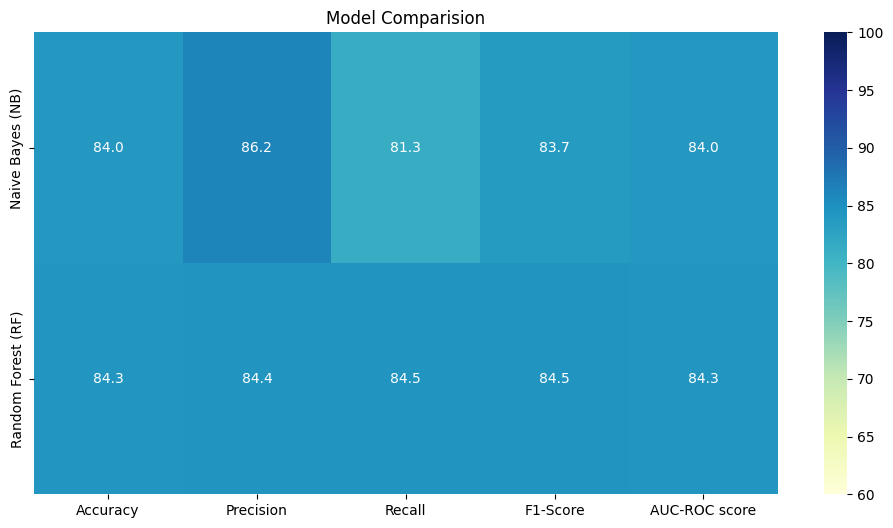

In [56]:
# Comparing All the models Scores
plt.figure(figsize=(12,6))
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.title('Model Comparision')
plt.show()

In [58]:
import joblib

#Saving the trained vectorizer
joblib.dump(tfidf,'tfidf_vectorizer.pkl')

#Save the trained RandomForest model
joblib.dump(RF_model, 'random_forest.pkl')

print("Vectorizer and model saved successfully!")


Vectorizer and model saved successfully!


In [78]:
# List of sample sentiment texts
sample_texts = [
    "The movie was absolutely fantastic! The storyline was gripping and the acting was superb.",
    "The movie was terrible and a complete waste of time.",
    "I loved the cinematography and the soundtrack was just perfect for the mood.",
    "Boring from start to finish, and the dialogue was cringeworthy.",
    "The visuals were stunning, but the plot fell flat and lacked depth.",
    "An absolute masterpiece! Worth watching again and again.",
    "It was so bad that I couldn't even finish watching it.",
    "Great performance by the lead actor, but the rest of the cast was mediocre at best.",
    "While I enjoyed the soundtrack, the storyline was confusing and poorly executed.",
    "This is one of the best movies I've ever seen. Highly recommended!"
]

# Loop through each sample text and predict sentiment
for text in sample_texts:

    sample_text_vectorized = tfidf.transform([text])


    predicted = RF_model.predict(sample_text_vectorized)


    sentiment = "Positive" if predicted[0] == 1 else "Negative"
    print(f"Text: {text}\nPrediction: {sentiment}\n")



Text: The movie was absolutely fantastic! The storyline was gripping and the acting was superb.
Prediction: Positive

Text: The movie was terrible and a complete waste of time.
Prediction: Negative

Text: I loved the cinematography and the soundtrack was just perfect for the mood.
Prediction: Positive

Text: Boring from start to finish, and the dialogue was cringeworthy.
Prediction: Negative

Text: The visuals were stunning, but the plot fell flat and lacked depth.
Prediction: Negative

Text: An absolute masterpiece! Worth watching again and again.
Prediction: Positive

Text: It was so bad that I couldn't even finish watching it.
Prediction: Negative

Text: Great performance by the lead actor, but the rest of the cast was mediocre at best.
Prediction: Positive

Text: While I enjoyed the soundtrack, the storyline was confusing and poorly executed.
Prediction: Positive

Text: This is one of the best movies I've ever seen. Highly recommended!
Prediction: Positive

